In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import utils
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score
import matplotlib.pyplot as plt
import pprint
import numpy as np

In [44]:
df=pd.read_csv("cleaned_data.csv")

In [3]:
params_dist={
    'n_estimators':np.arange(100,1000,100),
    'max_depth':np.arange(1,20,1),
    'max_features':['sqrt','log2',None],
    'min_samples_split':np.arange(2,10,1),
    'min_samples_leaf':np.arange(1,10,1),
    'bootstrap':[True,False]
}

In [4]:
rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),n_iter=100,random_state=42,scoring=[
    'roc_auc'
],param_distributions=params_dist,verbose=1,refit="roc_auc")

In [26]:
def compare_n_estimators(result):
    auc_high = result.query('mean_test_roc_auc >= 0.94')[['param_n_estimators','mean_test_roc_auc']]

    plt.scatter(result.param_n_estimators,
                result['mean_test_roc_auc'])
    plt.scatter(auc_high.param_n_estimators,
                auc_high['mean_test_roc_auc'],c='green',label='auc >94%')

    plt.title("auc per n_estimators ")
    plt.xlabel("n_estimators")

    plt.legend()
    plt.tight_layout()
    plt.show()
def compare_max_depth(result):
    auc_high = result.query('mean_test_roc_auc >= 0.94')[['param_max_depth','mean_test_roc_auc']]

    plt.scatter(result.param_max_depth,
                result['mean_test_roc_auc'])
    plt.scatter(auc_high.param_max_depth,
                auc_high['mean_test_roc_auc'],c='green',label='auc >94%')

    plt.title("auc per max_depth ")
    plt.xlabel("max_depth")

    plt.legend()
    plt.tight_layout()
    plt.show()

def compare_bootstrap(result):
    bootstrap_auc_score=result[['param_bootstrap','mean_test_roc_auc']].groupby('param_bootstrap').mean_test_roc_auc.max().sort_values(ascending=True)

    print(bootstrap_auc_score)



In [5]:
def store_result(base_model,base_score,rs:RandomizedSearchCV,rf_score):
    return (
        base_model,
        rs.best_estimator_
        ,{
            'best_params':rs.best_params_,
            'best_score':rs.best_score_,
            'base_score':base_score,
            'rf_score':rf_score,
            'diff':rf_score-base_score
        }
    )


## without Normalisation


In [6]:
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target')

In [7]:
base =RandomForestClassifier(random_state=42).fit(Xtrain,ytrain)
proba=base.predict_proba(Xtest)
base_score=roc_auc_score(ytest,proba[:,1])
print("base_score",base_score)

base_score 0.943196989925962


In [8]:
rf.fit(Xtrain,ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, refit='roc_auc', scoring=['roc_auc'],
                   verbose=1)

In [18]:
result=pd.DataFrame(rf.cv_results_)

In [20]:
result = result.replace({None:'None'}).dropna()

In [12]:
result.to_csv("RF-NoNorm-.csv",index=False)

In [ ]:
result[["params",'mean_test_roc_auc']].head()

,params,mean_test_roc_auc
0,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.924216
1,"{'n_estimators': 600, 'min_samples_split': 9, ...",0.910412
2,"{'n_estimators': 500, 'min_samples_split': 4, ...",0.924591
3,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.923514
4,"{'n_estimators': 700, 'min_samples_split': 6, ...",0.912090


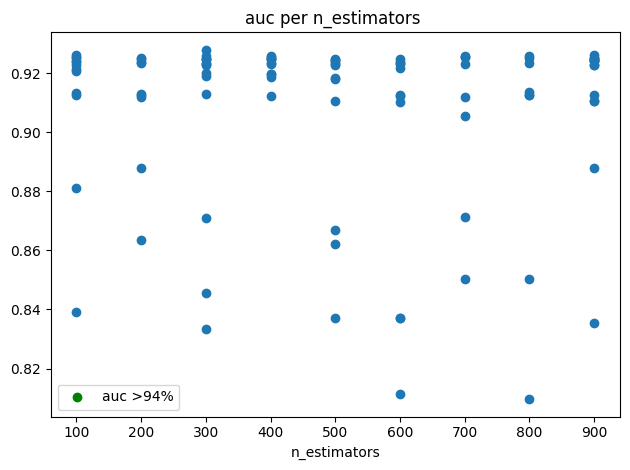

In [14]:
compare_n_estimators(result)

multiple values for n_Estimaors makes the performence of the model good



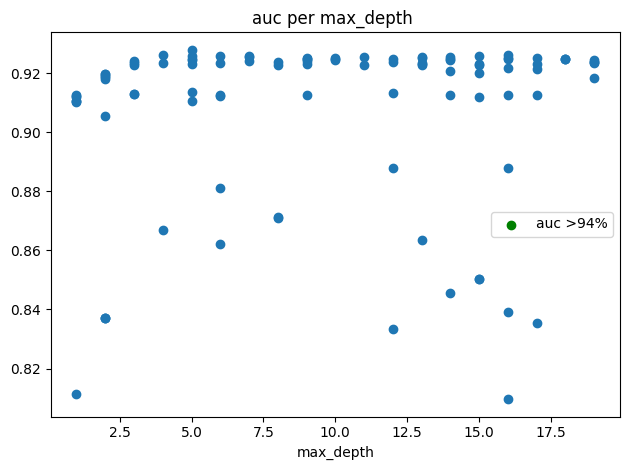

In [17]:
compare_max_depth(result)

multi combaination with multi max_depth values makes the model good


In [27]:
compare_bootstrap(result)

param_bootstrap
True     0.925938
False    0.927938
Name: mean_test_roc_auc, dtype: float64


when boostrap is False the model perform well


In [ ]:
proba=rf.predict_proba(Xtest)
score_rf=roc_auc_score(ytest,proba[:,1])

In [ ]:
artifact_rs_without_norm=store_result(base,base_score,rf,score_rf)

In [ ]:
artifact_rs_without_norm

(RandomForestClassifier(random_state=42),
 RandomForestClassifier(bootstrap=False, max_depth=np.int64(5),
                        max_features='log2', min_samples_leaf=np.int64(6),
                        min_samples_split=np.int64(6),
                        n_estimators=np.int64(300), random_state=42),
 {'best_params': {'n_estimators': np.int64(300),
   'min_samples_split': np.int64(6),
   'min_samples_leaf': np.int64(6),
   'max_features': 'log2',
   'max_depth': np.int64(5),
   'bootstrap': False},
  'best_score': np.float64(0.9279383525693641),
  'base_score': np.float64(0.943196989925962),
  'rf_score': np.float64(0.9356718048306834),
  'diff': np.float64(-0.007525185095278664)})

## with minmax


In [ ]:
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target','minmax')

In [ ]:
base =RandomForestClassifier(random_state=42).fit(Xtrain,ytrain)
proba=base.predict_proba(Xtest)
score=roc_auc_score(ytest,proba[:,1])
print("base_score",score)

base_score 0.9442893555043088


In [ ]:
rf.fit(Xtrain,ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, refit='roc_auc', scoring=['roc_auc'],
                   verbose=1)

In [ ]:
result_minmax=pd.DataFrame(rf.cv_results_)
result_minmax = result_minmax.replace({None:'None'}).dropna()
result_minmax.to_csv("RF-minmax.csv")

In [28]:
result_minmax=pd.read_csv("RF-minmax.csv")

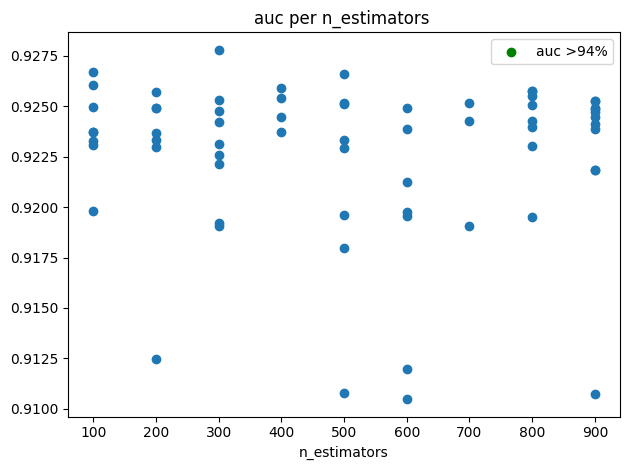

In [34]:
compare_n_estimators(result_minmax)

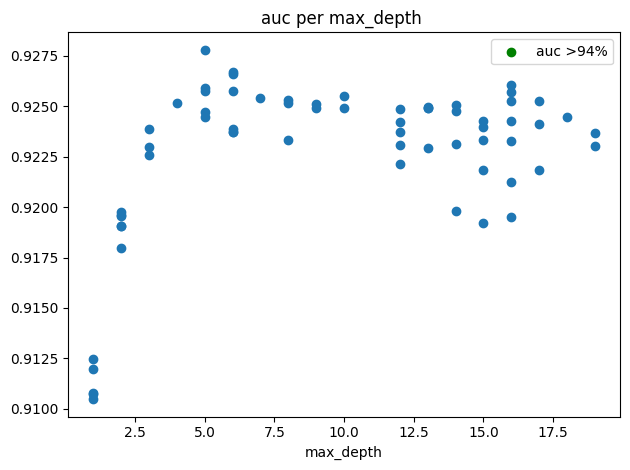

In [33]:
compare_max_depth(result_minmax)

In [32]:
compare_bootstrap(result_minmax)

param_bootstrap
True     0.92590
False    0.92779
Name: mean_test_roc_auc, dtype: float64


same as without normalisation

In [ ]:
proba=rf.predict_proba(Xtest)
score_rf=roc_auc_score(ytest,proba[:,1])

In [ ]:
artifact_rs_minmax=store_result(base,score,rf,score_rf)

## With Standard

In [ ]:
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target','standard')

In [ ]:
base =RandomForestClassifier(random_state=42).fit(Xtrain,ytrain)
proba=base.predict_proba(Xtest)
score=roc_auc_score(ytest,proba[:,1])
print("base_score",score)

base_score 0.9430756159728123


In [ ]:
rf.fit(Xtrain,ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, refit='roc_auc', scoring=['roc_auc'],
                   verbose=1)

In [ ]:
result_standard=pd.DataFrame(rf.cv_results_)
result_standard = result_standard.replace({None:'None'}).dropna()
result_standard.to_csv("RF-standard.csv")

In [35]:
result_standard=pd.read_csv("RF-standard.csv")

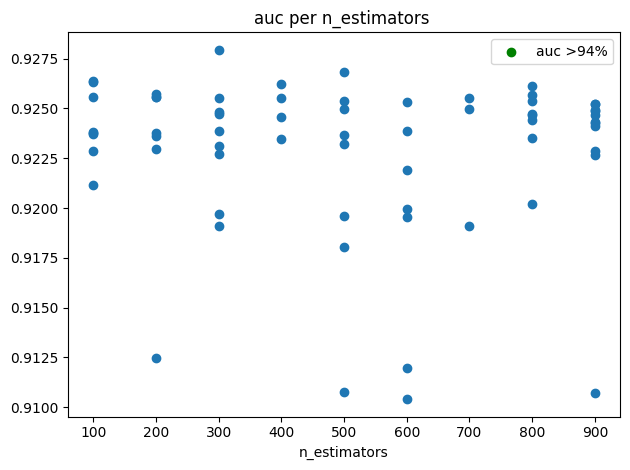

In [36]:
compare_n_estimators(result_standard)

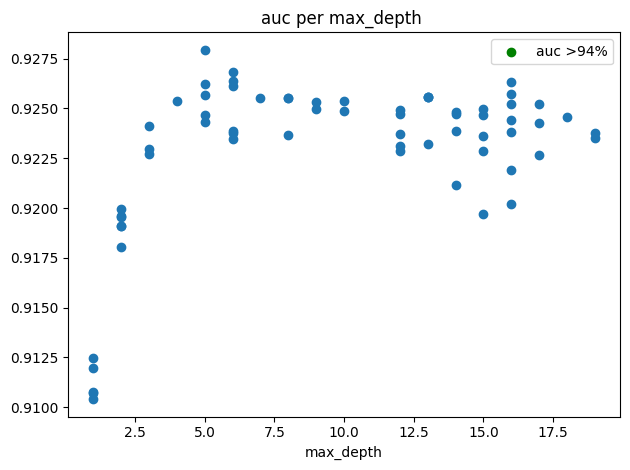

In [37]:
compare_max_depth(result_standard)

In [38]:
compare_bootstrap(result_standard)

param_bootstrap
True     0.926238
False    0.927938
Name: mean_test_roc_auc, dtype: float64


In [ ]:
proba=rf.predict_proba(Xtest)
score_rf=roc_auc_score(ytest,proba[:,1])

In [ ]:
artifact_rs_standard=store_result(base,score,rf,score_rf)

## comparaison between the base model and tunned model for auc

In [ ]:
pprint.PrettyPrinter(indent=4).pprint(artifact_rs_without_norm)

(   RandomForestClassifier(random_state=42),
    RandomForestClassifier(bootstrap=False, max_depth=np.int64(5),
                       max_features='log2', min_samples_leaf=np.int64(6),
                       min_samples_split=np.int64(6),
                       n_estimators=np.int64(300), random_state=42),
    {   'base_score': np.float64(0.943196989925962),
        'best_params': {   'bootstrap': False,
                           'max_depth': np.int64(5),
                           'max_features': 'log2',
                           'min_samples_leaf': np.int64(6),
                           'min_samples_split': np.int64(6),
                           'n_estimators': np.int64(300)},
        'best_score': np.float64(0.9279383525693641),
        'diff': np.float64(-0.007525185095278664),
        'rf_score': np.float64(0.9356718048306834)})


no improvement

In [ ]:
pprint.PrettyPrinter(indent=4).pprint(artifact_rs_minmax)

(   RandomForestClassifier(random_state=42),
    RandomForestClassifier(bootstrap=False, max_depth=np.int64(5),
                       max_features='log2', min_samples_leaf=np.int64(6),
                       min_samples_split=np.int64(6),
                       n_estimators=np.int64(300), random_state=42),
    {   'base_score': np.float64(0.9442893555043088),
        'best_params': {   'bootstrap': False,
                           'max_depth': np.int64(5),
                           'max_features': 'log2',
                           'min_samples_leaf': np.int64(6),
                           'min_samples_split': np.int64(6),
                           'n_estimators': np.int64(300)},
        'best_score': np.float64(0.927789720030599),
        'diff': np.float64(-0.008617550673625463),
        'rf_score': np.float64(0.9356718048306834)})


no improvement

In [ ]:
pprint.PrettyPrinter(indent=4).pprint(artifact_rs_standard)

(   RandomForestClassifier(random_state=42),
    RandomForestClassifier(bootstrap=False, max_depth=np.int64(5),
                       max_features='log2', min_samples_leaf=np.int64(6),
                       min_samples_split=np.int64(6),
                       n_estimators=np.int64(300), random_state=42),
    {   'base_score': np.float64(0.9430756159728123),
        'best_params': {   'bootstrap': False,
                           'max_depth': np.int64(5),
                           'max_features': 'log2',
                           'min_samples_leaf': np.int64(6),
                           'min_samples_split': np.int64(6),
                           'n_estimators': np.int64(300)},
        'best_score': np.float64(0.9279382548536776),
        'diff': np.float64(-0.007161063235829657),
        'rf_score': np.float64(0.9359145527369827)})


no improvment

## comparaison between the approch without normalisation and with normalisation

In [ ]:
without_norm_pred=artifact_rs_without_norm[0].predict(Xtest)
minmax_pred=artifact_rs_minmax[0].predict(Xtest)
standard_pred=artifact_rs_standard[0].predict(Xtest)

In [ ]:
without_norm_proba=artifact_rs_without_norm[0].predict_proba(Xtest)
minmax_proba=artifact_rs_minmax[0].predict_proba(Xtest)
standard_proba=artifact_rs_standard[0].predict_proba(Xtest)

In [ ]:
accuracy_score(ytest,without_norm_pred),accuracy_score(ytest,minmax_pred),accuracy_score(ytest,standard_pred)

(0.6739130434782609, 0.8152173913043478, 0.8858695652173914)

with standardisation we get high accuracy


In [ ]:
f1_score(ytest,without_norm_pred),f1_score(ytest,minmax_pred),f1_score(ytest,standard_pred)
#

(0.6470588235294118, 0.8349514563106796, 0.9004739336492891)

with standardisation we get high f1score





In [ ]:
roc_auc_score(ytest,without_norm_proba[:,1]),roc_auc_score(ytest,minmax_proba[:,1]),roc_auc_score(ytest,standard_proba[:,1])
#

(np.float64(0.7491807258162398),
 np.float64(0.9001699235344095),
 np.float64(0.9430756159728123))

with standardisation we get high auc





In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

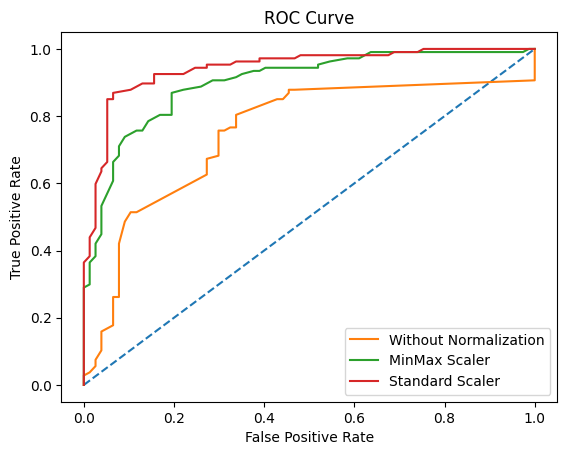

In [ ]:
fp_norm_none,tp_norm_none,_ = roc_curve(ytest,without_norm_proba[:,1])
fp_minmax,tp_minmax,_       = roc_curve(ytest,minmax_proba[:,1])
fp_standard,tp_standard,_   = roc_curve(ytest,standard_proba[:,1])

plt.figure()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


plt.plot([0,1],[0,1], linestyle='--')

plt.plot(fp_norm_none,tp_norm_none, label="Without Normalization")
plt.plot(fp_minmax,tp_minmax, label="MinMax Scaler")
plt.plot(fp_standard,tp_standard, label="Standard Scaler")

plt.legend()
plt.show()


# Threshold tunning

In [ ]:
import numpy as np

thresolds=np.arange(0.1,1,0.01)
result_f1_score=[]
for thresold in thresolds:
    y_pred_none = (without_norm_proba[:,1] >= thresold).astype(int)
    y_pred_minmax = (minmax_proba[:,1] >= thresold).astype(int)
    y_pred_std = (standard_proba[:,1] >= thresold).astype(int)
    result_f1_score.append([
        f1_score(ytest,y_pred_none),
        f1_score(ytest,y_pred_minmax),
        f1_score(ytest,y_pred_std),
    ])



In [ ]:
np.max(result_f1_score,axis=0)

array([0.79661017, 0.86511628, 0.90825688])

In [ ]:
thresolds[np.argmax(result_f1_score,axis=0)[2]]

np.float64(0.3599999999999999)

# hyperparameter tuning with Optuna

In [57]:
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target','standard')

In [41]:
import optuna

In [48]:
def objective(trial):
  params={
      'n_estimators':trial.suggest_int('n_estimators',100,1000),
      'max_depth':trial.suggest_int('max_depth',1,20),
      'max_features':trial.suggest_categorical('max_features',['sqrt','log2',None]),
      'min_samples_split':trial.suggest_int('min_samples_split',2,10),
      'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
      'bootstrap':trial.suggest_categorical('bootstrap',[True,False])

  }
  model = RandomForestClassifier(random_state=42,**params)
  model.fit(Xtrain,ytrain)
  proba=model.predict_proba(Xtest)
  score=roc_auc_score(ytest,proba[:,1])
  return score

In [58]:
study = optuna.create_study(direction='maximize',study_name='rfc-tuning')
study.optimize(objective,n_trials=100)

[I 2025-11-02 09:43:29,775] A new study created in memory with name: rfc-tuning
[I 2025-11-02 09:43:31,476] Trial 0 finished with value: 0.9316664643767448 and parameters: {'n_estimators': 495, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.9316664643767448.
[I 2025-11-02 09:43:32,460] Trial 1 finished with value: 0.9154630416312659 and parameters: {'n_estimators': 739, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.9316664643767448.
[I 2025-11-02 09:43:33,090] Trial 2 finished with value: 0.9425901201602136 and parameters: {'n_estimators': 311, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 2 with value: 0.9425901201602136.
[I 2025-11-02 09:43:34,786] Trial 3 finished with value: 0.941740502488166 and parameters: {'n_estimators': 9

In [59]:
study.best_params

{'n_estimators': 996,
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'bootstrap': False}

In [60]:
study.best_value

0.9456244689889549

threshold 0.3599 is the best for the model